In [91]:
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Predict model performance

In [92]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [93]:
DATA_PATH = 'data/aggregated/experiments.csv'

Data

In [94]:
df = pd.read_csv(DATA_PATH)
df.head(5)

,topology,cells_number,possible_moves,connection_degree,depth,mean_log2_max_tile
0,hex,19,6,4.11,2,11.275
1,hex,19,6,4.11,1,11.105
2,hex,19,6,4.11,4,13.065
3,hex,19,6,4.11,3,13.130
4,hex,19,6,4.11,0,9.120


Model training

In [95]:
features = ['cells_number', 'possible_moves', 'connection_degree', 'depth']
X = df[features].values
y = df['mean_log2_max_tile'].values

In [96]:
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()

Evaluating

In [97]:
X_pred = sm.add_constant(X)
y_pred = model.predict(X_pred)

In [98]:
df['predicted_mean_log2_max_tile'] = y_pred
df_comparison = df[['depth', 'cells_number', 'possible_moves', 'connection_degree', 'mean_log2_max_tile', 'predicted_mean_log2_max_tile']]

Understanding the model

In [99]:
summary_df = pd.DataFrame({
    "feature": ["intercept", "cells_number", "possible_moves", "connection_degree", "depth"],
    "coef": model.params,
    "std_error": model.bse,
    "p_value": model.pvalues
})
summary_df

,feature,coef,std_error,p_value
0,intercept,-3.472595,0.978178,0.004552
1,cells_number,0.235551,0.042153,0.000163
2,possible_moves,0.310154,0.085329,0.003924
3,connection_degree,1.718051,0.431369,0.002149
4,depth,0.807000,0.105598,0.000010


Comparing predicted performance across different depths











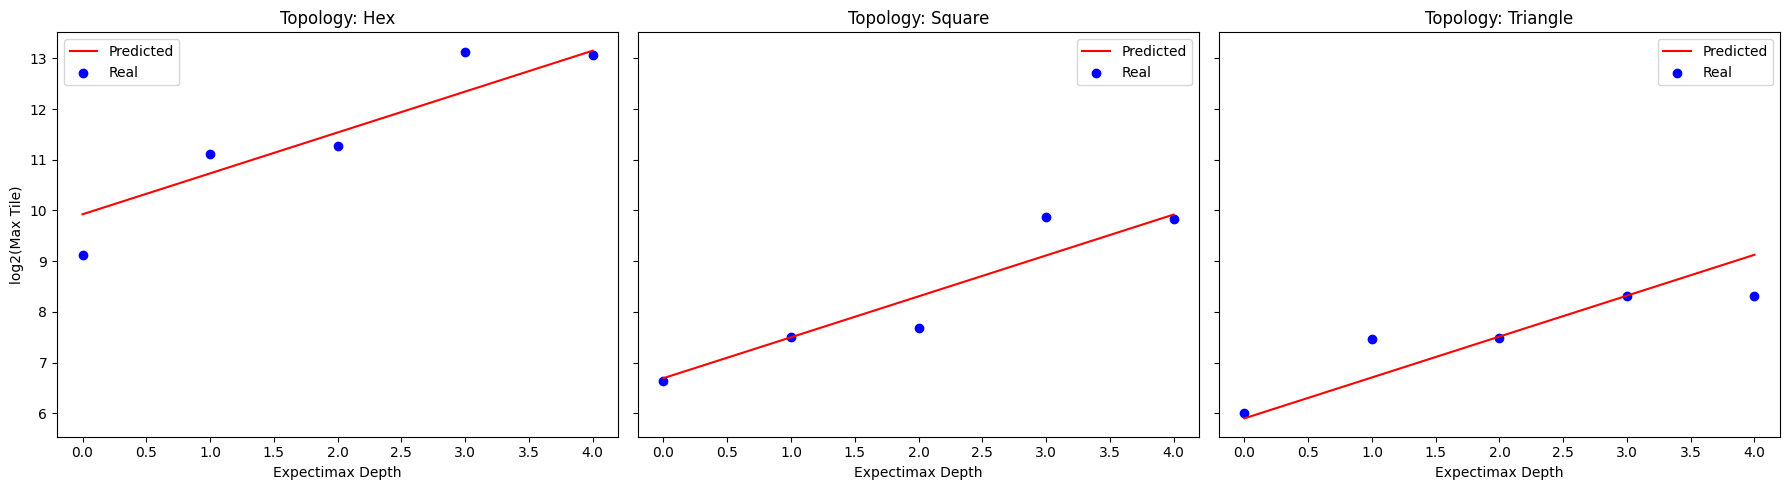

In [101]:
topologies = df["topology"].unique()
n_topos = len(topologies)

fig, axes = plt.subplots(nrows=1, ncols=n_topos, figsize=(6 * n_topos, 5), sharey=True)

if n_topos == 1:
    axes = [axes]

for ax, topo in zip(axes, topologies):
    topo_df = df[df["topology"] == topo].sort_values("depth")
    
    ax.plot(
        topo_df["depth"],
        topo_df["predicted_mean_log2_max_tile"],
        color='red',
        linestyle='-',
        label="Predicted"
    )

    ax.scatter(
        topo_df["depth"],
        topo_df["mean_log2_max_tile"],
        color='blue',
        marker='o',
        label="Real"
    )
    
    ax.set_title(f"Topology: {topo.capitalize()}")
    ax.set_xlabel("Expectimax Depth")
    ax.legend()

axes[0].set_ylabel("log2(Max Tile)")

plt.tight_layout()
plt.show()